### DeepONet, trunk with Transformer and branch with CNN


In [21]:
import numpy as np
import torch
import xarray as xr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path if needed

z_full = ds['z_aac'].values
x_full = ds['x_caa'].values

z_sel_idx = np.linspace(0, len(z_full)-1, 50, dtype=int)
x_sel_idx = np.linspace(0, len(x_full)-1, 128, dtype=int)

z_vals = z_full[z_sel_idx]
x_vals = x_full[x_sel_idx]

def slice_field(field, z_dim, x_dim):
    return np.array(field.isel({z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

max_time_steps = 50
b = slice_field(ds['b'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')
u = slice_field(ds['u'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_faa')
w = slice_field(ds['w'].isel(time=slice(0, max_time_steps)), 'z_aaf', 'x_caa')
p_dyn = slice_field(ds['p_dyn'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')

time = np.array(ds['time'].isel(time=slice(0, max_time_steps)).values, dtype=np.float32)

delta_b = b[1:] - b[:-1]
time_d = time[1:]

inputs = np.stack([u[:-1], w[:-1], p_dyn[:-1]], axis=1).astype(np.float32)
targets = delta_b.astype(np.float32)
time_stamps = time_d.astype(np.float32)

subset = min(10, inputs.shape[0])
inputs_mean = inputs[:subset].mean()
inputs_std = inputs[:subset].std()
inputs_norm = (inputs - inputs_mean) / (inputs_std + 1e-8)

targets_mean = targets[:subset].mean()
targets_std = targets[:subset].std()
targets_norm = (targets - targets_mean) / (targets_std + 1e-8)

time_min, time_max = time_stamps.min(), time_stamps.max()
time_norm = (time_stamps - time_min) / (time_max - time_min)

X_tensor = torch.tensor(inputs_norm, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(targets_norm, dtype=torch.float32).to(device)
t_tensor = torch.tensor(time_norm, dtype=torch.float32).unsqueeze(1).to(device)

train_idx = np.arange(0, 30)
test_idx = np.arange(30, 49)

X_train, Y_train, t_train = X_tensor[train_idx], Y_tensor[train_idx], t_tensor[train_idx]
X_test, Y_test, t_test = X_tensor[test_idx], Y_tensor[test_idx], t_tensor[test_idx]

print("✅ Preprocessing Done:", X_train.shape, Y_train.shape, t_train.shape)


C:\Users\deban\AppData\Local\Temp\ipykernel_22132\376530028.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path if needed


✅ Preprocessing Done: torch.Size([30, 3, 50, 128]) torch.Size([30, 50, 128]) torch.Size([30, 1])


In [22]:
import torch.nn as nn

class TransformerTrunk(nn.Module):
    def __init__(self, embed_dim=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerTrunk, self).__init__()
        self.embedding = nn.Linear(1, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.proj = nn.Linear(embed_dim, 50 * 128)

    def forward(self, t):
        t_embed = self.embedding(t)              # (B, 1, embed_dim)
        t_encoded = self.transformer(t_embed)    # (B, 1, embed_dim)
        out = self.proj(t_encoded.squeeze(1))    # (B, 50*128)
        return out.view(-1, 50, 128)

class CNNBranch(nn.Module):
    def __init__(self):
        super(CNNBranch, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        out = self.cnn(x).squeeze(1)  # (B, 50, 128)
        return out

class PINN_Transformer(nn.Module):
    def __init__(self):
        super(PINN_Transformer, self).__init__()
        self.branch = CNNBranch()
        self.trunk = TransformerTrunk()

    def forward(self, x, t):
        B_out = self.branch(x)            # (B, 50, 128)
        T_out = self.trunk(t)             # (B, 50, 128)
        return B_out * T_out


In [23]:
def compute_physics_loss(model, X_in, t_in, κ=1e-3, dz=1.0, dx=1.0):
    pred = model(X_in, t_in)  # (B, 50, 128)

    # ===== Spatial Derivatives =====
    b_x = (pred[:, :, 2:] - pred[:, :, :-2]) / (2 * dx)           # (B, 50, 126)
    b_z = (pred[:, 2:, :] - pred[:, :-2, :]) / (2 * dz)           # (B, 48, 128)

    # ===== Crop Inputs to Match =====
    u_crop = X_in[:, 0, :, 1:-1]           # (B, 50, 126) — match b_x
    w_crop = X_in[:, 1, 1:-1, :]           # (B, 48, 128) — match b_z

    # ===== Advection Terms =====
    advec_x = u_crop * b_x                 # (B, 50, 126)
    advec_z = w_crop * b_z                 # (B, 48, 128)

    # ===== Second Derivatives =====
    b_xx = (pred[:, :, :-2] - 2 * pred[:, :, 1:-1] + pred[:, :, 2:]) / (dx ** 2)  # (B, 50, 126)
    b_zz = (pred[:, :-2, :] - 2 * pred[:, 1:-1, :] + pred[:, 2:, :]) / (dz ** 2)  # (B, 48, 128)

    diff_x = b_xx                          # (B, 50, 126)
    diff_z = b_zz                          # (B, 48, 128)

    # ===== Match Spatial Shapes: Crop deeper =====
    min_z = min(advec_x.shape[1], advec_z.shape[1], diff_z.shape[1])
    min_x = min(advec_x.shape[2], advec_z.shape[2], diff_x.shape[2])

    advec_x = advec_x[:, :min_z, :min_x]
    advec_z = advec_z[:, :min_z, :min_x]
    diff_x = diff_x[:, :min_z, :min_x]
    diff_z = diff_z[:, :min_z, :min_x]

    # ===== Combine =====
    advection = advec_x + advec_z
    diffusion = κ * (diff_x + diff_z)

    loss = torch.mean((advection - diffusion) ** 2)
    return loss


In [24]:
model = PINN_Transformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

epochs = 3000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train, t_train)
    
    obs_loss = mse(pred, Y_train)
    phy_loss = compute_physics_loss(model, X_train, t_train)
    smoothness_loss = torch.mean((pred[:, :, 1:] - pred[:, :, :-1]) ** 2) + torch.mean((pred[:, 1:, :] - pred[:, :-1, :]) ** 2)
    
    total_loss = obs_loss * 0.5 + 1 * phy_loss + 0.01 * smoothness_loss
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Obs={obs_loss.item():.5f}, Phy={phy_loss.item():.5f}, Smooth={smoothness_loss.item():.5f}")


Epoch 0: Obs=0.61848, Phy=0.00023, Smooth=0.00164
Epoch 500: Obs=0.26067, Phy=0.02601, Smooth=0.48273
Epoch 1000: Obs=0.17557, Phy=0.02830, Smooth=0.65632
Epoch 1500: Obs=0.16156, Phy=0.02833, Smooth=0.70470
Epoch 2000: Obs=0.14574, Phy=0.03211, Smooth=0.83178
Epoch 2500: Obs=0.12391, Phy=0.03288, Smooth=0.84245


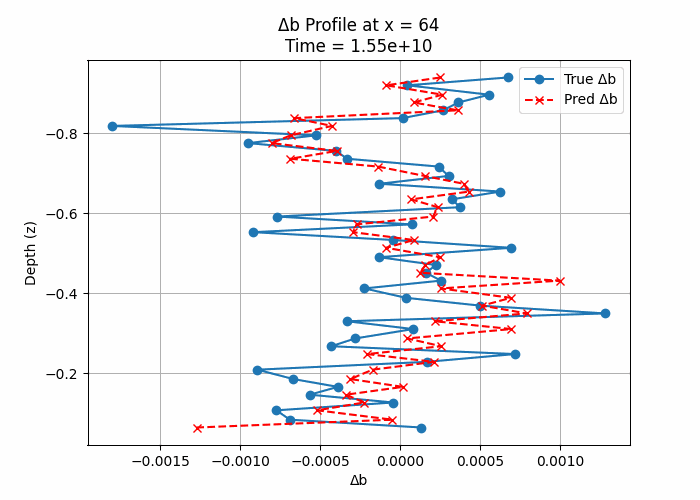

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display, HTML

# ===== 1. Set Model to Eval and Predict =====
model.eval()
with torch.no_grad():
    pred_test = model(X_test, t_test)               # (B_test, 50, 128)
    pred_test_np = pred_test.cpu().numpy()
    Y_test_np = Y_test.cpu().numpy()

# ===== 2. Unnormalize =====
pred_test_np = pred_test_np * targets_std + targets_mean
Y_test_np = Y_test_np * targets_std + targets_mean

# ===== 3. Time Handling =====
# Use time_stamps for unnormalized time values → select matching time indices
time_test_np = time_stamps[test_idx]  # Already in float32

# ===== 4. Prepare Data for Plotting (Central x slice) =====
x_idx = 64
trim_start = 3
trim_end = -3

z_trimmed = z_vals[trim_start:trim_end]

b_true_list = []
b_pred_list = []

for i in range(pred_test_np.shape[0]):
    b_true_i = Y_test_np[i, trim_start:trim_end, x_idx]
    b_pred_i = pred_test_np[i, trim_start:trim_end, x_idx]
    b_true_list.append(b_true_i)
    b_pred_list.append(b_pred_i)

# ===== 5. Create Animation =====
fig, ax = plt.subplots(figsize=(7, 5))

def update(frame):
    ax.clear()
    ax.plot(b_true_list[frame], z_trimmed, label='True Δb', marker='o')
    ax.plot(b_pred_list[frame], z_trimmed, label='Pred Δb', linestyle='--', marker='x', color='red')
    ax.set_title(f'Δb Profile at x = {x_idx}\nTime = {time_test_np[frame]:.2e}')
    ax.set_xlabel('Δb')
    ax.set_ylabel('Depth (z)')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(b_true_list), blit=False, interval=1000)

# Save as GIF + Display
ani.save('Transformer_PINN_deltab.gif', writer='pillow', fps=0.5)
display(Image(filename='Transformer_PINN_deltab.gif'))

plt.close(fig)
display(HTML(ani.to_jshtml()))
